In [ ]:
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from math import pi
import numpy as np

In [133]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', threaded=True)
drone = Drone(conn)
drone.start()

Logs/TLog.txt


# Play with drone API

In [134]:
drone.take_control()

In [135]:
drone.arm()

In [136]:
drone.armed, drone.connected, drone.guided

(True, True, True)

In [137]:
drone.set_home_position(drone.global_position[0], 
                        drone.global_position[1], 
                        drone.global_position[2])
drone.global_position, drone.global_home

(array([-122.3957525,   37.7932828,    0.152    ]),
 array([-122.3957517,   37.7932817,    0.       ]))

In [138]:
drone.takeoff(3)

In [139]:
drone.cmd_position(0, 0, 3, 0)

In [140]:
drone.cmd_position(5, 0, 3,np.pi/2)

In [41]:
drone.cmd_position(5, 5, 10, pi)

In [42]:
drone.cmd_position(0, 5, 6, 3*pi/2)

In [43]:
drone.cmd_position(0, 0, 3, 0)

In [29]:
drone.disarm()
drone.release_control()

# Parse logs

In [2]:
import pandas as pd
log = './Logs/TLog.txt'

In [8]:
parsed = Drone.read_telemetry_data(log)
parsed.keys()

dict_keys(['MsgID.GLOBAL_POSITION', 'MsgID.LOCAL_VELOCITY', 'MsgID.LOCAL_POSITION', 'MsgID.STATE', 'MsgID.GLOBAL_HOME'])

In [9]:
df = pd.read_csv(log,header=None)\
    .rename(columns={0: 'message', 1: 'timestamp'})\
    .assign(timestamp=lambda frame: pd.to_datetime(frame.timestamp * 10**9))\
    .set_index('timestamp')
print(df.shape)
df.head(3)

(354, 4)


,message,2,3,4
timestamp,,,,
2018-05-23 14:54:15.779232000,MsgID.GLOBAL_POSITION,-122.3956287,37.7933738,0.239000
2018-05-23 14:54:15.779232000,MsgID.LOCAL_VELOCITY,0.0000000,0.0000000,0.000000
2018-05-23 14:54:15.779527936,MsgID.LOCAL_POSITION,0.0842777,0.1025428,-0.239838


## Signal frequencies

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

message
MsgID.GLOBAL_HOME         19
MsgID.GLOBAL_POSITION     79
MsgID.LOCAL_POSITION      79
MsgID.LOCAL_VELOCITY     158
MsgID.STATE               19
dtype: int64

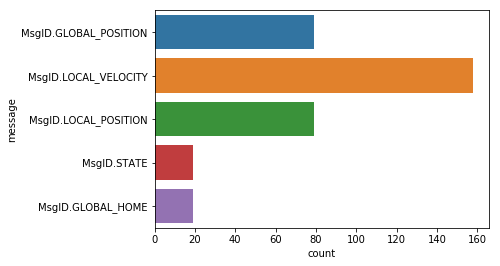

In [15]:
sns.countplot(y='message', data=df)
df.groupby('message').size()

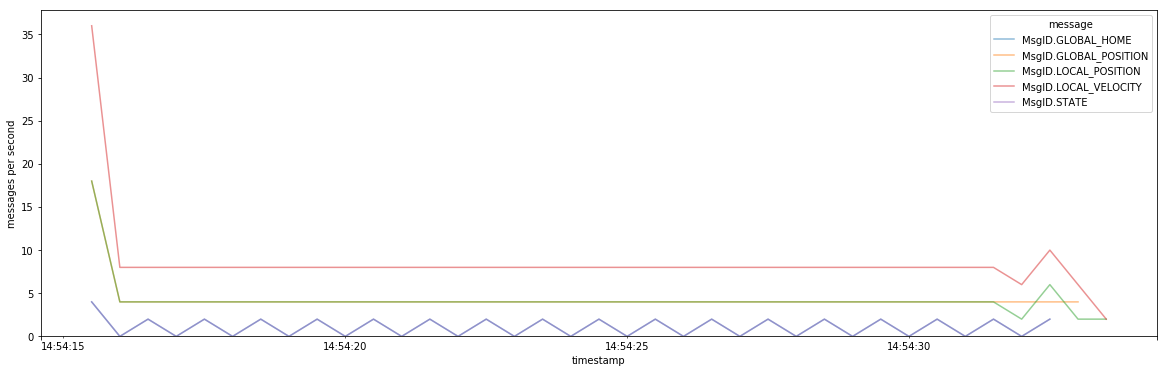

In [48]:
df.groupby('message')\
    .resample('500ms')\
    .size()\
    .unstack('message')\
    .mul(2)\
    .plot(figsize=(20,6), alpha=0.5)
plt.ylim((0, None))
plt.ylabel('messages per second')
None

After an initial burst, it looks like the emission frequencies are constant and not affected by changing values.

## Signal values

In [108]:
local_coords = df[df.message.isin(['MsgID.LOCAL_POSITION', 'MsgID.LOCAL_VELOCITY'])]\
    .rename(columns={2: 'x', 3: 'y', 4: 'z'})\
    .pivot(columns='message')\
    .astype('double')\
    .reorder_levels([1, 0], axis=1)\
    .sort_index(axis=1)
local_coords.head(8)

message                       MsgID.LOCAL_POSITION                      \
                                                 x         y         z   
timestamp                                                                
2018-05-23 14:54:15.779232000                  NaN       NaN       NaN   
2018-05-23 14:54:15.779527936             0.084278  0.102543 -0.239838   
2018-05-23 14:54:15.779725312                  NaN       NaN       NaN   
2018-05-23 14:54:15.779921920            -0.130644 -0.024676 -0.258762   
2018-05-23 14:54:15.780078336                  NaN       NaN       NaN   
2018-05-23 14:54:15.780232960            -0.053448  0.102532 -0.268069   
2018-05-23 14:54:15.781366016                  NaN       NaN       NaN   
2018-05-23 14:54:15.781539072            -0.003305  0.189011 -0.269127   

message                       MsgID.LOCAL_VELOCITY            
                                                 x    y    z  
timestamp                                                     
2018-05-23 14:54:15.779232000                  0.0  0.0  0.0  
2018-05-23 14:54:15.779527936                  0.0  0.0 -0.0  
2018-05-23 14:54:15.779725312                  0.0  0.0  0.0  
2018-05-23 14:54:15.779921920                  0.0  0.0 -0.0  
2018-05-23 14:54:15.780078336                  0.0  0.0  0.0  
2018-05-23 14:54:15.780232960                  0.0  0.0 -0.0  
2018-05-23 14:54:15.781366016                  0.0  0.0  0.0  
2018-05-23 14:54:15.781539072                  0.0  0.0 -0.0

Text(0.5,1,'velocity coordinates over time')

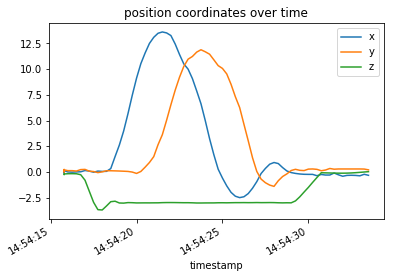

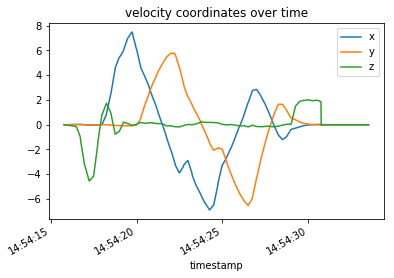

In [122]:
local_positions = local_coords['MsgID.LOCAL_POSITION'].dropna()
local_positions.plot()
plt.title('position coordinates over time')
plt.figure()
local_velocities = local_coords['MsgID.LOCAL_VELOCITY']
local_velocities.plot()
plt.title('velocity coordinates over time')

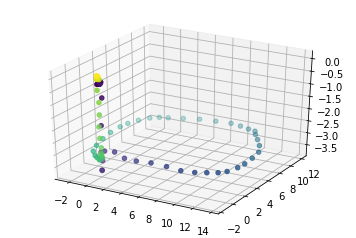

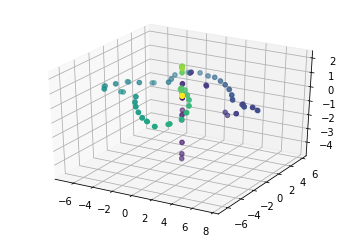

In [123]:
ax = plt.axes(projection='3d')
ax.scatter3D(local_positions.x, local_positions.y, local_positions.z, c=local_positions.index)

plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(local_velocities.x, local_velocities.y, local_velocities.z, c=local_velocities.index)